In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

smoke_test = ('CI' in os.environ)

/Users/sina/Library/Mobile Documents/com~apple~CloudDocs/Git_Projects/Deep-probabilistic-modeling/PyroVenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: Geography and national income

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


/var/folders/6q/mv1t578n5dd41214yd5lkclh0000gn/T/ipykernel_1273/2298758561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


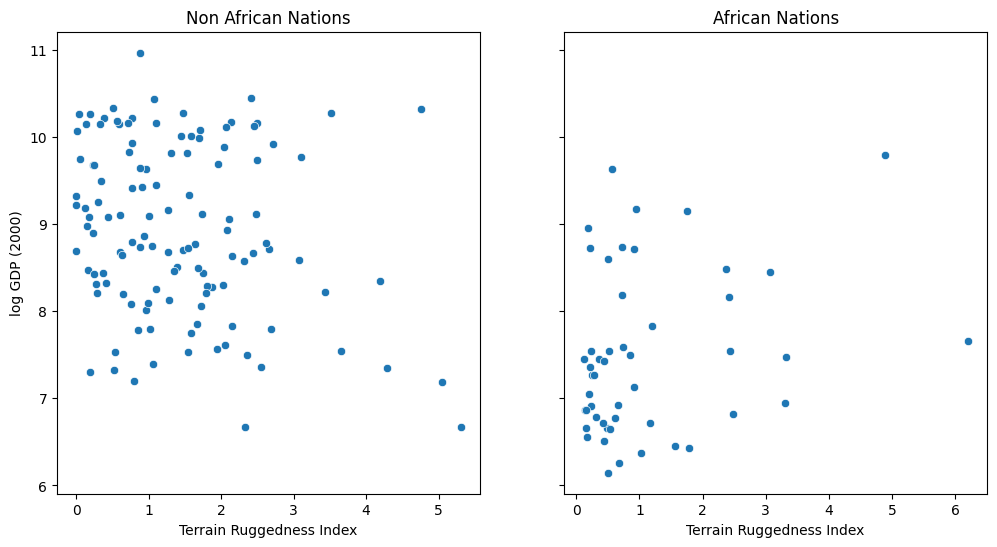

In [3]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Models in Pyro

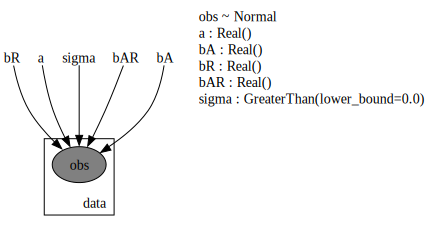

In [4]:
# maximum-likelihood linear regression

"""
If we write out the formula for our linear regression predictor
BX + a
as a Python expression, we get the following:
"""
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)
    
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp),
                   render_distributions=True, render_params=True)

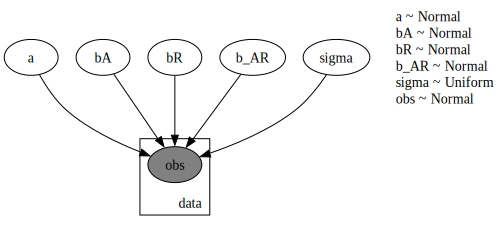

In [5]:
# from maximum-likelihood regression to Bayesian regression

def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("b_AR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    
pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

## Inference in Pyro

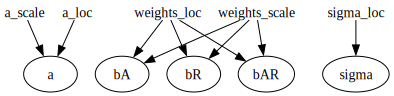

In [6]:
# mean-field variational approximation for Bayesian linear regression in Pyro

"""
Background: “guide” programs as flexible approximate posteriors
In variational inference, we introduce a parameterized distribution 
 to approximate the true posterior, where 
 are known as the variational parameters. This distribution is called the variational
 distribution in much of the literature, and in the context of Pyro it’s 
 called the guide (one syllable instead of nine!).

 Just like the model, the guide is encoded as a Python program guide()
 that contains pyro.sample and pyro.param statements.
 It does not contain observed data, since the guide needs to be a properly
 normalized distribution so that it is easy to sample from. Note that Pyro enforces
 that model() and guide() should take the same arguments.

 Allowing guides to be arbitrary Pyro programs opens up the possibility of
 writing guide families that capture more of the problem-specific structure of
 the true posterior, expanding the search space in only helpful directions,
 as depicted schematically in the figure below.
"""

def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                           constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda:torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a":a, "b_a":b_a, "b_r":b_r, "b_ar":b_ar, "sigma":sigma}

pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp),render_params=True)

In [7]:
"""
Pyro also contains an extensive collection of “autoguides” which automatically
 generate guide programs from a given model. Like our handwritten guide,
 all pyro.autoguide.AutoGuide instances (which are themselves just functions
 that take the same arguments as the model) return a dictionary of values for
 each pyro.sample site they contain.

 The simplest autoguide class is AutoNormal, which automatically generates a guide
 in a single line of code that is equivalent to the one we wrote out by hand above:
"""

auto_guide = pyro.infer.autoguide.AutoNormal(model)

AutoNormal.locs.a 9.1997385
AutoNormal.scales.a 0.06948285
AutoNormal.locs.bA -1.8118304
AutoNormal.scales.bA 0.12762174
AutoNormal.locs.bR -0.17627202
AutoNormal.scales.bR 0.036276296
AutoNormal.locs.b_AR 0.32519937
AutoNormal.scales.b_AR 0.073997125
AutoNormal.locs.sigma -2.2717826
AutoNormal.scales.sigma 0.044418994


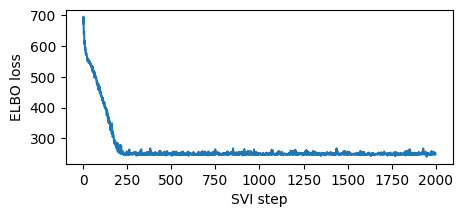

In [8]:
# Estimating and optimizing the Evidence Lower Bound (ELBO)

"""
The functional of model and guide that we will optimize is the ELBO,
defined as an expectation w.r.t. to samples from the guide.

By assumption we can compute all of the probabilities inside the expectation, and since the guide "q"
is assumed to be a parametric distribution we can sample from, we can compute Monte Carlo estimates
of this quantity as well as of gradients with respect to model and guide parameters.

Optimizing the ELBO over model and guide parameters 
via stochastic gradient descent using these gradient estimates is sometimes called stochastic
variational inference (SVI).

"""

## example: Bayesian regression via stochastic variational inference (SVI)

adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

"""
To take an ELBO gradient step we simply call the step method of SVI.
The data argument we pass to SVI.step will be passed to both model() and guide().
The complete training loop is as follows:
"""

pyro.clear_param_store()

## These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.05}) # consider decreasing learning rate
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(2000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}". format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

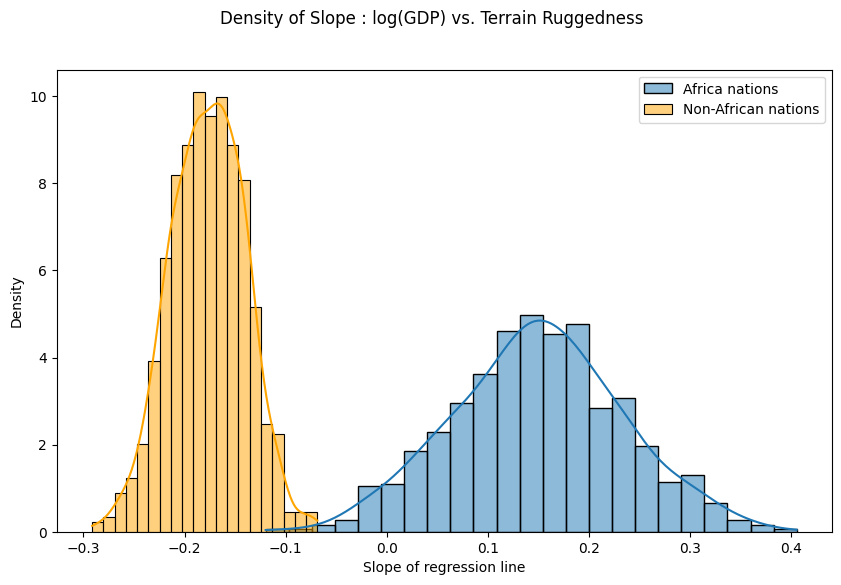

In [9]:
"""
Finally, let us revisit our earlier question of how robust the relationship
between terrain ruggedness and GDP is against any uncertainty in the parameter
estimates from our model. For this, we plot the distribution of the slope of the
log GDP given terrain ruggedness for nations within and outside Africa.

We represent these two distributions with samples drawn from our trained guide.
To draw multiple samples in parallel, we can call the guide within a pyro.plate
statement which repeats and vectorizes the sampling operations for each pyro.
sample statement in the guide, as described in the section introducing the pyro.
plate primitive.
"""

with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["b_AR"]
gamma_outside_africa = samples["bR"]

fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="Africa nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

## Model evaluation in Pyro

In [10]:
# Example: posterior predictive uncertainty in Pyro

"""
To evaluate our example linear regression model, we’ll generate and visualize some samples
from the posterior predictive distribution using the Predictive utility class, which implements
the recipe above for sampling approximately from "P(x'|X)"

We generate 800 samples from our trained model. Internally, this is done by first generating samples
for the latent variables from the guide, and then running the model forward while changing the values
returned by unobserved pyro.sample statements to the corresponding values sampled from the guide.
"""

predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

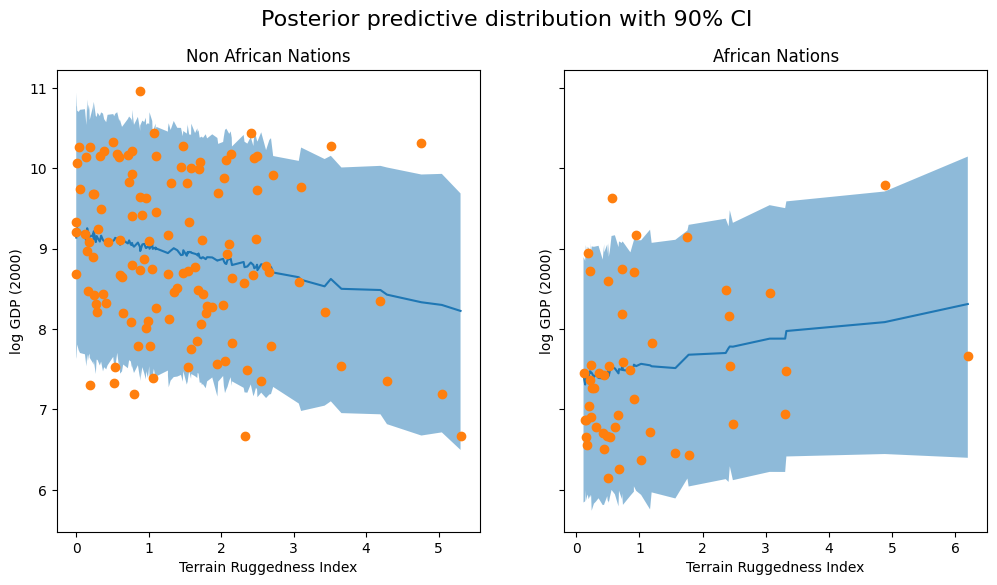

In [11]:
"""
The code below is specific to this example and is simply used to plot the 90% credible interval
(the interval containing 90% of the probability mass) of the posterior predictive distribution for each country.
"""

predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})

african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

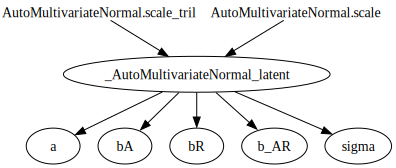

In [12]:
"""
To improve our results, we will try using a guide that generates samples from a multivariate normal distribution over
all parameters. This allows us to capture the correlations between the latent variables via a full-rank covariance matrix.

To write a guide of this form manually, we would need to combine all the latent variables so we could pyro.sample them
together from a single pyro.distributions.MultivariateNormal distribution, choose an implementation of to fix the value of 
to be positive, create and initialize parameters  of the appropriate shape, and constrain the variational parameter 
to remain a valid covariance matrix (i.e. stay positive-definite) throughout the optimization process.

This would be quite tedious, so instead we will use another autoguide that takes care of all of this bookkeeping for us,
pyro.infer.autoguide.AutoMultivariateNormal:
"""

mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

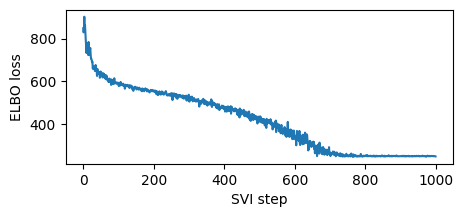

In [13]:
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())
losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["b_AR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# interface note: reuse guide samples for predctions by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above

assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

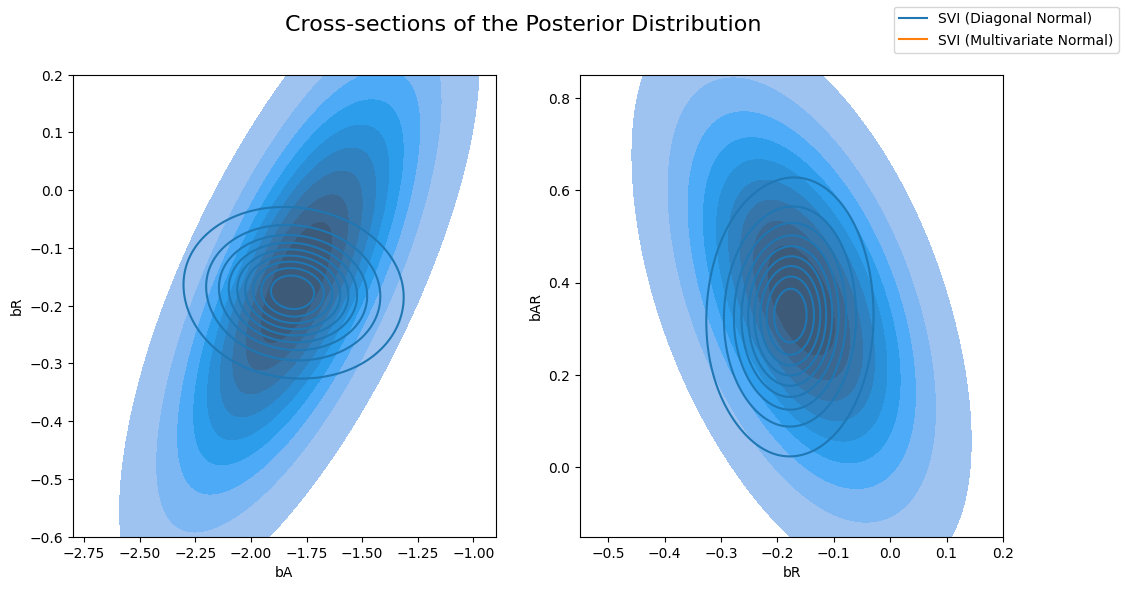

In [14]:
""""
Now let’s compare the posterior computed by the previous AutoDiagonalNormal guide vs the AutoMultivariateNormal guide.
We will visually overlay cross-sections of the posterior distribution.
Note that the multivariate normal approximation is more dispersed than the mean-field approximation,
and is able to model correlations between coefficients in the posterior.
"""

svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], fill=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["b_AR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["b_AR"], ax=axs[1], fill=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

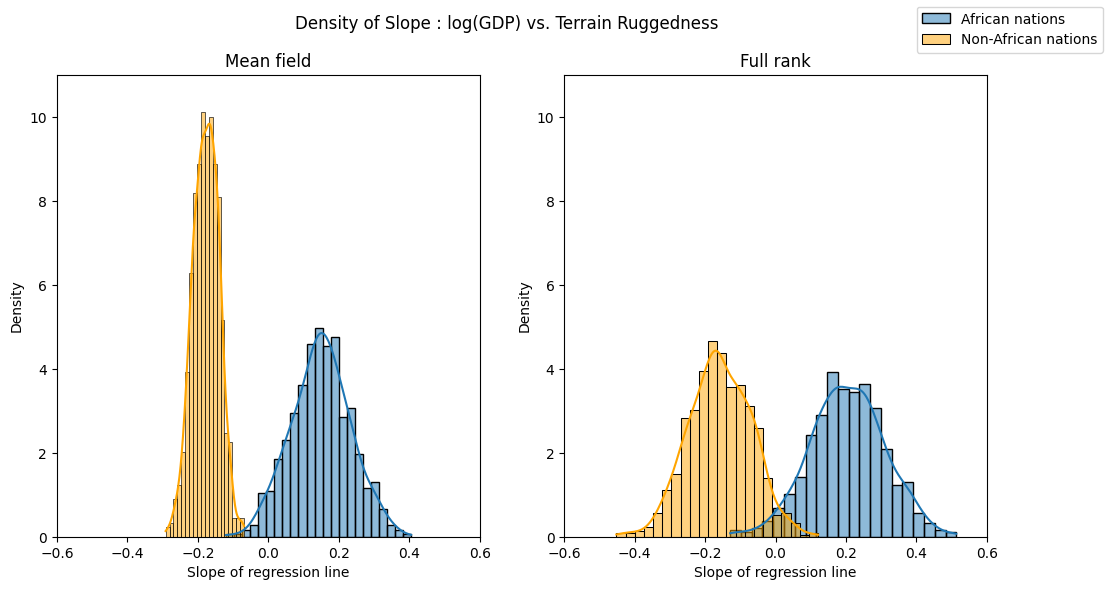

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

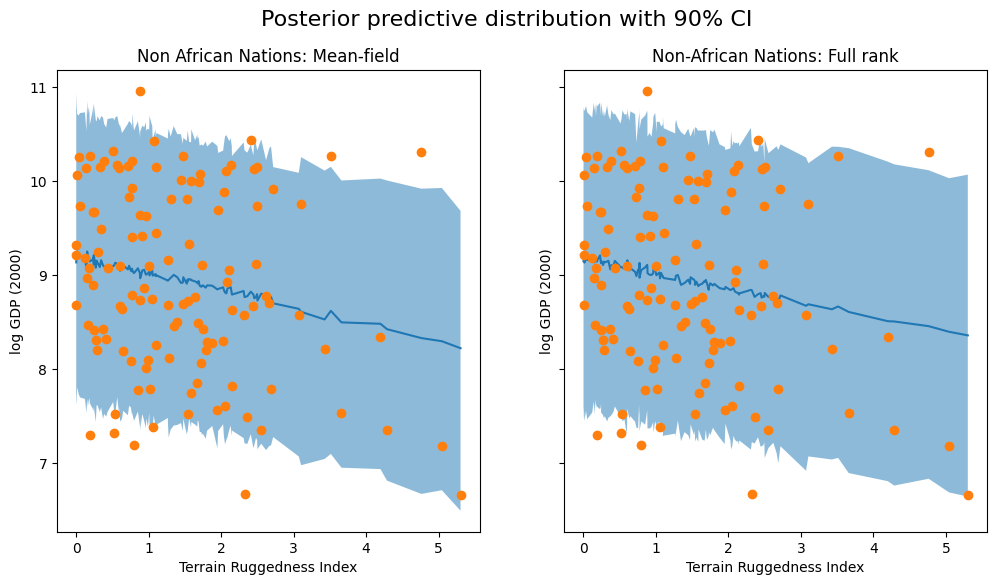

In [20]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");